# Последовательный анализ

## Библиотеки

In [2]:
import numpy as np
import sprt
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt

## Warmup

### Генерация данных

- $p_L$ - нижняя граница
- $p_U$ - верхняя граница
- $\alpha$ - уровень значимости, допускаемая вероятность ошибки первого рода: отвергнуть верную $H_0$ (при $p \le p_L$)
- $\beta$ - допускаемая вероятность ошибки второго рода: принять неверную $H_0$ (при $p \ge p_U$)

In [3]:
pl = 0.45
pu = 0.55
alpha = beta = 0.05
A = (1 - beta) / alpha
B = beta / (1 - alpha)

def a_m(m):
    return (np.log(B) + m * np.log((1 - pl) / (1 - pu))) / (np.log(pu / pl) - np.log((1 - pu) / (1 - pl)))

def r_m(m):
    return (np.log(A) + m * np.log((1 - pl) / (1 - pu))) / (np.log(pu / pl) - np.log((1 - pu) / (1 -pl)))

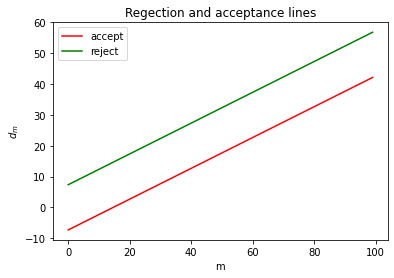

In [4]:
plt.plot(range(100), [a_m(i) for i in range(100)], label='accept', color='red')
plt.plot(range(100), [r_m(i) for i in range(100)], label='reject', color='green')
plt.xlabel('m')
plt.ylabel('$d_m$')
plt.legend(loc='best')

plt.title('Regection and acceptance lines')

plt.show()

### Z-критерий меток для доли (лекция 2: параметрические гипотезы) и последовательный анализ для проверки $p$

Сравним результаты последовательного анализа и z-теста меток для доли

Последовательный анализ:

$H_0:\ p \le p_L$ 

$H_1:\ p \ge p_U$

Критерий меток доли (левосторонняя альтернатива):

$H_0:\ p = p_0$ 

$H_1:\ p < p_0$

#### Генерация данных ($Ber(p)$) и проверка z-критерием меток

In [5]:
def generate_and_test(real_p, test_func, maxm=500, seed=42):
    """
    Генерация выборки из бернуллиевских величин, генерация останавливается, когда при последовательном анализе мы отвергаем
    или принимаем H_0 и одновременно то же делает z-test
    :param real_p - p
    :param test_func - функция для проверки z-теста, возвращает p-value
    :param maxm - максимальный размер выборки
    :return полученная выборка, массив p-value, номер первой итерации, где график вышел за пределы полосы
    """
    rs = np.random.RandomState(seed)
    sample = []
    pvals = []
    m = 0
    test_iter_num = -1 # номер итерации, где отвергается гипотеза по z-тесту
    iter_num = -1 # номер итерации, где мы выходим за пределы области безразличия (между двумя accept и reject)
    while m < maxm and (iter_num < 0 or test_iter_num < 0):
        m += 1
        x = rs.uniform() <= real_p
        sample += [x]
        pvals.append(test_func(sample))
        if iter_num < 0 and (np.sum(sample) <= a_m(m) or np.sum(sample) >= r_m(m)):
            iter_num = m
            
        if pvals[-1] < 0.05:
            test_iter_num = m

    return sample, pvals, iter_num

In [6]:
def plot_seq_ztest_results(sample, bin_test):
    max_l = len(sample)
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(np.cumsum(sample), label='actual d_m')
    ax1.plot(range(max_l), [a_m(i) for i in range(max_l)], label='accept', color='green')
    ax1.plot(range(max_l), [r_m(i) for i in range(max_l)], label='reject', color='red')
    ax1.legend(loc='best')
    ax1.set_xlabel('m')
    ax1.set_ylabel('$d_m$')
    ax1.set_title('Sequential analysis')

    ax2 = fig.add_subplot(122)
    ax2.plot(bin_test)
    ax2.set_xlabel('m')
    ax2.set_ylabel('p-value')
    ax2.set_title('Z-tests')

#### $p=0.4$

/home/hp/.local/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


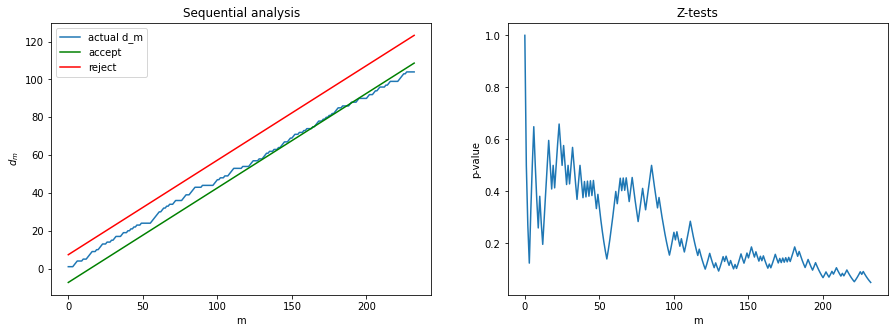

In [14]:
sample, bin_test, _ = generate_and_test(0.4, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller')[1])
plot_seq_ztest_results(sample, bin_test)

#### $p=0.6$

/home/hp/.local/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


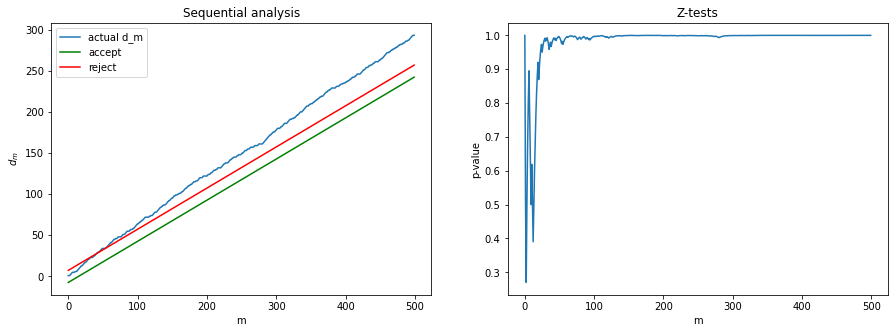

In [15]:
sample, bin_test, _ = generate_and_test(0.6, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller')[1])
plot_seq_ztest_results(sample, bin_test)

#### $p=0.5$

/home/hp/.local/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


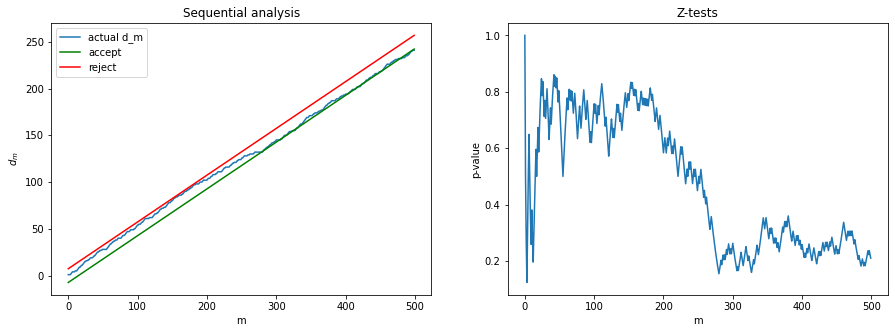

In [16]:
sample, bin_test, _ = generate_and_test(0.5, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller')[1])
plot_seq_ztest_results(sample, bin_test)

#### Рассмотрим разный random_state

379


Text(0, 0.5, 'p-value')

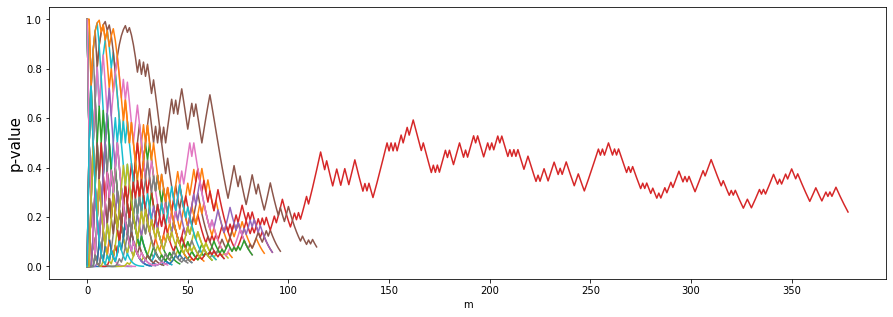

In [19]:
max_l = 0
bin_tests = []
iter_nums = []
for i in range(30):
    sample_, bin_test, iter_num = generate_and_test(0.4, seed=i, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller' )[1])
    max_l_ = len(sample_)
    max_l = max(max_l_, max_l)
    iter_nums.append(iter_num)
    bin_tests.append(bin_test)
print(max_l)

plt.figure(figsize=(15, 5))
for t in bin_tests:
    plt.plot(t)        
plt.xlabel('m')
plt.ylabel('p-value', fontdict={'size': 15})

#### Разница в размерах итоговых выборок

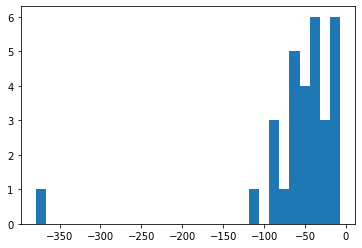

In [20]:
min_num = []
for p in bin_tests:
    min_num.append(np.where(np.array(p) <= 0.05)[0][0])
min_num = np.array(min_num)
plt.hist(min_num-np.array(iter_nums), bins=30)

plt.show()

#### Последовательный тест Вальда из коробки
- $h_0 == H_0$ 
- $h_1 == H_1$

Decision:	Reject

     values    lower    upper
n                            
491     236  213.521  228.045
492     236  213.971  228.495
493     237  214.421  228.944
494     238  214.870  229.394
495     239  215.320  229.844
496     240  215.770  230.293
497     240  216.219  230.743
498     241  216.669  231.193
499     241  217.119  231.642
500     241  217.568  232.092


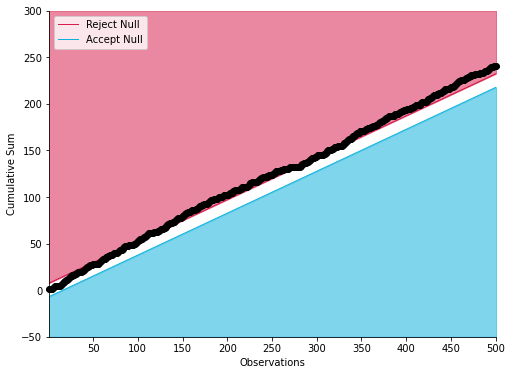

In [21]:
rs = np.random.RandomState(42)
values = rs.uniform(size=500) <= 0.5
test = sprt.SPRTBinomial(alpha=alpha, beta=beta, h0=0.4, h1=0.5, values=values)
test.plot()

plt.show()

## Метилфенидат и синдром дефицита внимания

24 умственно отсталых ребёнка с СДВГ в течение недели принимали либо метилфенидат, либо плацебо, а в конце недели проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, после недельного курса каждый испытуемые проходили второй тест.

Каков эффект препарата?

### Данные

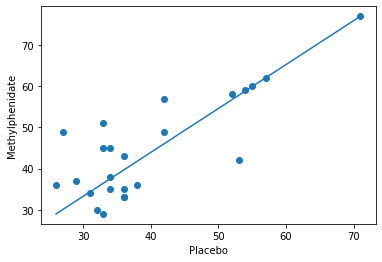

In [22]:
att = np.loadtxt('data/ADHD.txt', delimiter=' ', skiprows=1)


plt.scatter(att[:, 0], att[:, 1])
plt.xlabel('Placebo')
plt.ylabel('Methylphenidate')
_ = plt.plot([min(att[:,0]), max(att[:,0])], [min(att[:, 1]), max(att[:, 1])])

### Нормальность дельт

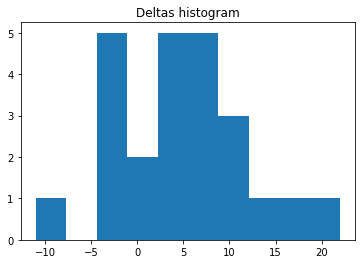

In [23]:
deltas = att[:, 1] - att[:, 0]
plt.hist(deltas)
_ = plt.title('Deltas histogram')

In [24]:
st.shapiro(deltas)

ShapiroResult(statistic=0.9798055291175842, pvalue=0.8922544717788696)

### Последовательный анализ Вальда для нормального распределенияи

Рассмотрим, как меняется коридор безразличия при изменении $\alpha$ и $\beta$ (предполагаем, что дисперсия известна, так как иначе это будет t-тест, а не z-тест).

$H_0: \mu \le \mu_L$

$H_1: \mu \ge \mu_U$

- $p_L$ - нижняя граница
- $p_U$ - верхняя граница
- $\alpha$ - уровень значимости, допускаемая вероятность ошибки первого рода: отвергнуть верную $H_0$ (при $p \le p_L$)
- $\beta$ - допускаемая вероятность ошибки второго рода: принять неверную $H_0$ (при $p \ge p_U$)

In [25]:
mean = np.mean(deltas)
var = np.std(deltas, ddof=1)**2

Decision:	Continue

    values   lower    upper
n                          
15    91.0 -64.045  138.420
16    96.0 -61.566  140.900
17    93.0 -59.087  143.379
18   100.0 -56.608  145.858
19    97.0 -54.129  148.337
20   102.0 -51.650  150.816
21   103.0 -49.170  153.295
22   111.0 -46.691  155.775
23   123.0 -44.212  158.254
24   119.0 -41.733  160.733


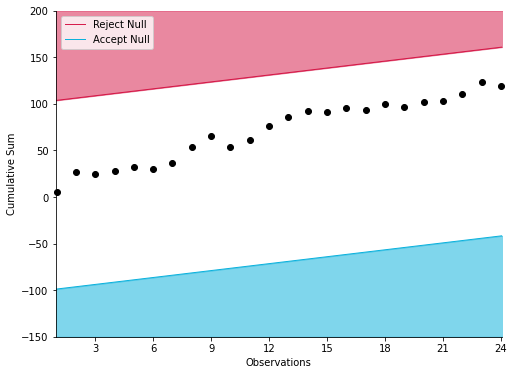

In [26]:
test = sprt.SPRTNormal(alpha=0.05, beta=0.05, h0=mean / 3,  h1=2 * mean / 3, values=deltas, variance=var)
test.plot()

Decision:	Continue

    values   lower    upper
n                          
15    91.0 -60.221  100.649
16    96.0 -57.742  103.128
17    93.0 -55.263  105.607
18   100.0 -52.784  108.087
19    97.0 -50.305  110.566
20   102.0 -47.826  113.045
21   103.0 -45.346  115.524
22   111.0 -42.867  118.003
23   123.0 -40.388  120.482
24   119.0 -37.909  122.962


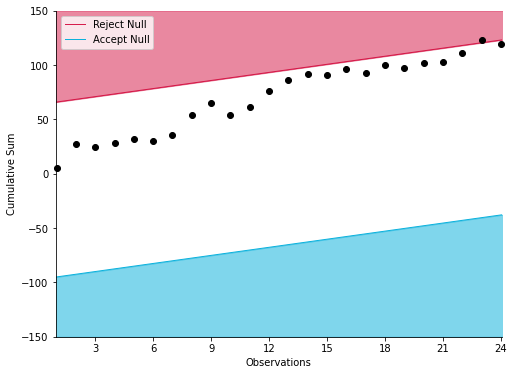

In [27]:
test = sprt.SPRTNormal(alpha=0.15, beta=0.05, h0=mean / 3,  h1=2 * mean / 3, values=deltas, variance=var)
test.plot()

Decision:	Continue

    values   lower    upper
n                          
15    91.0 -26.274  134.596
16    96.0 -23.795  137.076
17    93.0 -21.316  139.555
18   100.0 -18.837  142.034
19    97.0 -16.357  144.513
20   102.0 -13.878  146.992
21   103.0 -11.399  149.471
22   111.0  -8.920  151.951
23   123.0  -6.441  154.430
24   119.0  -3.962  156.909


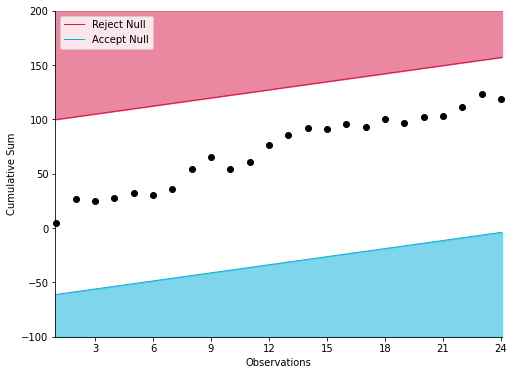

In [28]:
test = sprt.SPRTNormal(alpha=0.05, beta=0.15, h0=mean / 3,  h1=2 * mean / 3, values=deltas, variance=var)
test.plot()

Decision:	Continue

    values   lower    upper
n                          
15    91.0  -0.482   92.120
16    96.0   2.824   95.426
17    93.0   6.130   98.731
18   100.0   9.435  102.037
19    97.0  12.741  105.342
20   102.0  16.046  108.648
21   103.0  19.352  111.954
22   111.0  22.657  115.259
23   123.0  25.963  118.565
24   119.0  29.268  121.870


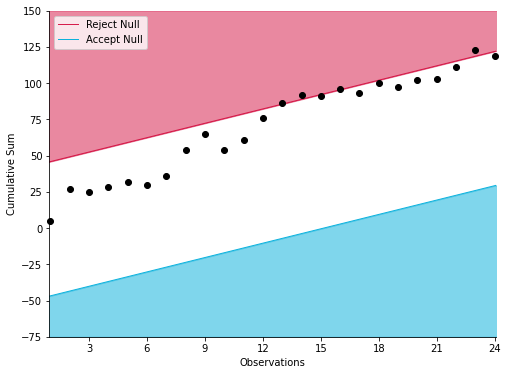

In [29]:
test = sprt.SPRTNormal(alpha=0.08, beta=0.05, h0=mean / 3,  h1=3 * mean / 3, values=deltas, variance=var)
test.plot()